In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import pyreadr
import pandas as pd
from itertools import product
import multiprocessing as mp
from ml_par import sample_ll, sample_ll_multiple
from scipy.spatial import distance_matrix

# Define functions

In [2]:
def corr_func(h, r, s):
    res = np.exp(-np.power((h/r),s))
    return res    

In [3]:
def s_term(z1, z2, h, r, s):
    res = np.sqrt(1 - 2 * (corr_func(h, r, s)+1) * (z1 * z2)/np.power((z1+z2),2))
    return res

In [4]:
def s_term_dev(z1, z2, h, r, s):
    res = (1/( s_term(z1, z2, h, r, s))) * (-(corr_func(h, r, s) + 1 )) * \
          z2 * (z1+z2) * ((z1+z2)- 2 * z1)/np.power((z1+z2), 4)
    return res

In [5]:
def s_term_dev_2(z1, z2, h, r, s):
    term_1 = (-1/np.power(s_term(z1,z2,h,r,s),2)) * s_term_dev(z2,z1,h,r,s) * \
             (z2/np.power(z1+z2,2) - (2*z1*z2)/np.power(z1+z2,3))
    
    
    term_2 = (1/s_term(z1,z2,h,r,s)) * ((z1-z2)/np.power(z1+z2,3) - (2*z1*z1-4*z1*z2)/np.power(z1+z2,4))
    
    res = -(corr_func(h,r,s)+1)*(term_1+term_2)
    return res

In [6]:
def V(z1, z2, h, r, s):
    res = 0.5 * (1/z1 + 1/z2) * (1 + s_term(z1, z2, h, r, s))
    return res

In [7]:
def V1(z1, z2, h, r, s):
    res = 0.5 * (-1/np.power(z1, 2)*(1+s_term(z1, z2, h, r, s)) + \
                 (1/z1 + 1/z2)*s_term_dev(z1,z2,h,r,s))
    return res

In [8]:
def V2(z1, z2, h, r, s):
    res = V1(z2, z1, h, r, s)
    return res

In [9]:
def V12(z1, z2, h, r, s):
    res = 0.5 * ((-1/np.power(z1,2)) * s_term_dev(z2, z1, h, r, s) + \
          (-1/np.power(z2,2)) * s_term_dev(z1, z2, h, r, s) + (1/z1 + 1/z2) * s_term_dev_2(z1, z2, h, r, s))
    return res

In [10]:
def logl(z1, z2, h, r, s):
    res = np.log(V1(z1, z2, h, r, s) * V2(z1, z2, h, r, s) - V12(z1, z2, h, r, s))- V(z1, z2, h, r, s)
    return res

# Plot functions

In [11]:
z = np.linspace(0.1, 30, 300)

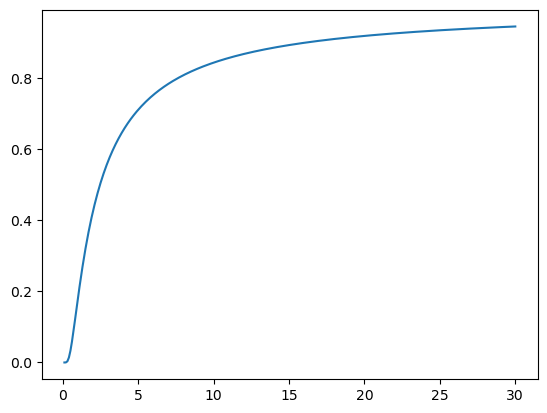

In [12]:
# CDF
y = np.exp(-V(z, z, 20, 2.5, 2))
plt.plot(z,y)

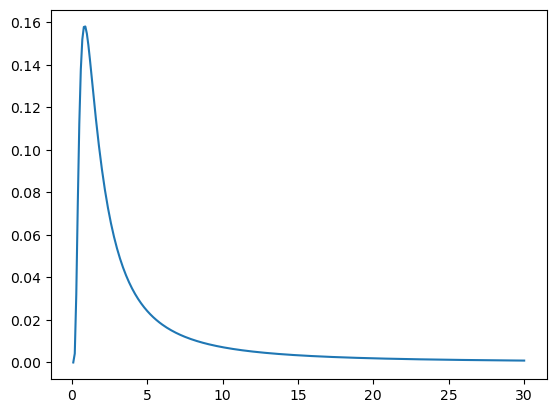

In [13]:
# V1 derivative
y = np.exp(-V(z, z, 20, 2.5, 2)) * -V1(z, z, 20, 2.5, 2)
plt.plot(z,y)

In [14]:
# Test integration
true = np.exp(-V(10, 5, 20, 2.5, 2))
true

0.7696623253130903

In [15]:
result = integrate.quad(lambda x: np.exp(-V(10, x, 20, 2.5, 2)) * - V2(10, x, 20, 2.5, 2), 0, 5)

In [16]:
result

(0.7696623253130873, 1.929347192259702e-09)

In [17]:
# Test integration of second derivative
true = s_term_dev(5, 5, 2, 2.5, 2) - s_term_dev(5, 2, 2, 2.5, 2)
true

-0.043534175810169315

In [18]:
result = integrate.quad(lambda x: s_term_dev_2(5, x, 2, 2.5, 2), 2, 5)

In [19]:
result

(-0.043534175810169315, 4.83326443425295e-16)

In [20]:
# Test final integration
true = np.exp(-V(3, 2, 10, 1.5, 2))
true

0.48815159642646433

In [21]:
func = lambda y,x: np.exp(-V(x, y, 10, 1.5, 2)) * (V1(x, y, 20, 2.5, 2) * V2(x, y, 10, 1.5, 2)- V12(x, y, 10, 1.5, 2))
result = integrate.dblquad(func, 10e-5, 3, 10e-5, 2)
result

(0.4881515964263373, 1.4828006831624148e-08)

# Evalute log likelihood

In [11]:
# Load example data
exp = "exp_4"
path = f'../data/{exp}/data/'
sample = 120
length = 625
test_data = pyreadr.read_r(path+"powexp_test_data.RData")["test_data"].to_numpy()
test_params = pyreadr.read_r(path+"powexp_test_params.RData")["test_params"].to_numpy()
data_sample = test_data[:,sample]
param_sample = test_params[sample]
print(param_sample)

[0.99513994 1.3447954 ]


In [12]:
x = np.linspace(0,25,25)
grid = np.array(list(product(x, repeat = 2)))

In [13]:
sample_space = 20
r = np.linspace(0.01, 5 ,sample_space)
s = np.linspace(0.01,2, sample_space)
r_plot, s_plot = np.meshgrid(r,s)

In [14]:
param_grid = np.zeros(shape = ((len(r)*len(s)),3))
param_grid[:,0:2] = np.array(list(product(r, s)))

In [15]:
distmat = distance_matrix(grid, grid)
data_expanded = np.repeat(np.expand_dims(data_sample,1), length, axis = 1)

In [27]:
def collect_result(result):
    global param_grid
    data, sample = result    
    param_grid[sample,2] = data

In [28]:
pool = mp.Pool(mp.cpu_count()-1)

In [29]:
# Run parallel
for t in range(sample_space**2):
    result = pool.apply_async(sample_ll, args = (t, param_grid, grid, data_expanded, distmat, 5), callback = collect_result)
pool.close()
pool.join()

In [30]:
z = np.transpose(np.reshape(param_grid[:,2], (len(r), len(s))))

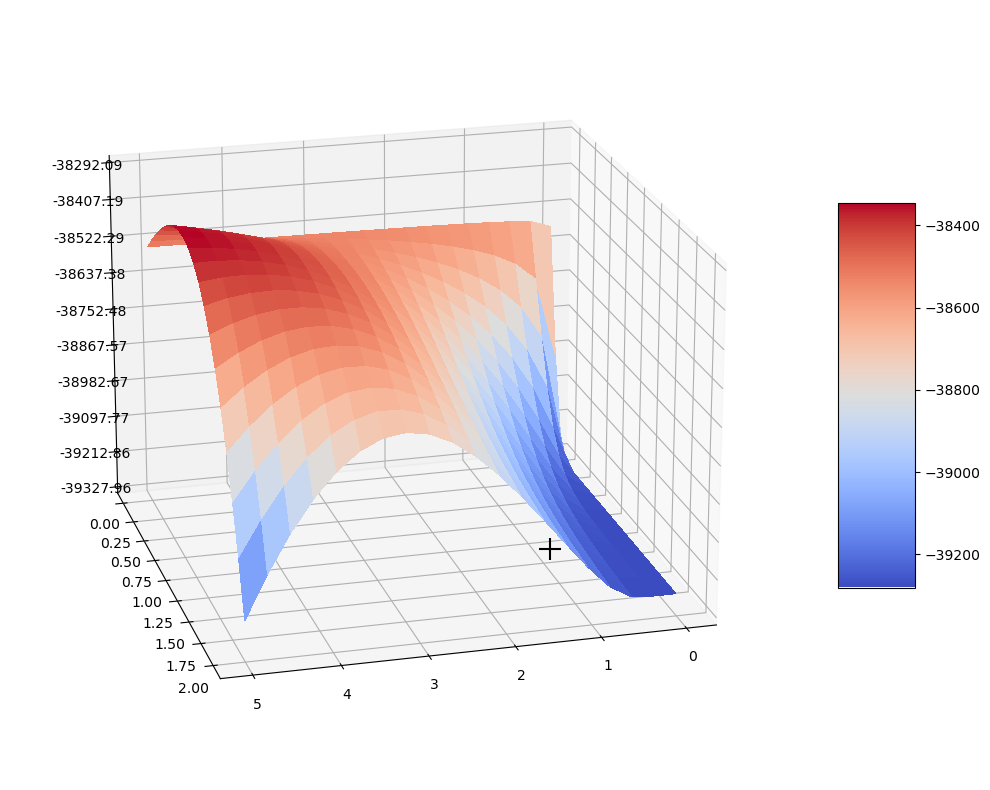

In [49]:
from matplotlib import cm
from matplotlib.ticker import LinearLocator

fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize = (15,10))
# Set up plot
surf = ax.plot_surface(r_plot, s_plot, z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
#ax.set_zlim(-1.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.02f}')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.scatter(param_sample[0], param_sample[1], z.min(), color = "black", marker = "+", s = 250)


ax.view_init(20, 75)
plt.show()

# Calculate likelihood with multiple samples

In [40]:
sample_space = 10
r = np.linspace(0.01, 5 ,sample_space)
s = np.linspace(0.01,2, sample_space)
r_plot, s_plot = np.meshgrid(r,s)

In [41]:
param_grid_2 = np.zeros(shape = ((len(r)*len(s)),3))
param_grid_2[:,0:2] = np.array(list(product(r, s)))

In [42]:
data_sample = test_data[:,sample:sample+30]
param_sample = test_params[sample]

In [43]:
data_expanded = np.repeat(np.expand_dims(data_sample,2), length, axis = 2)

In [44]:
def collect_result(result):
    global param_grid_2
    data, sample = result    
    param_grid_2[sample,2] = data

In [45]:
pool = mp.Pool(mp.cpu_count()-1)

In [46]:
# Run parallel
for t in range(sample_space**2):
    result = pool.apply_async(sample_ll_multiple, args = (t, param_grid_2, grid, data_expanded, distmat, 5), callback = collect_result)
pool.close()
pool.join()

In [47]:
z2 = np.transpose(np.reshape(param_grid_2[:,2], (len(r), len(s))))

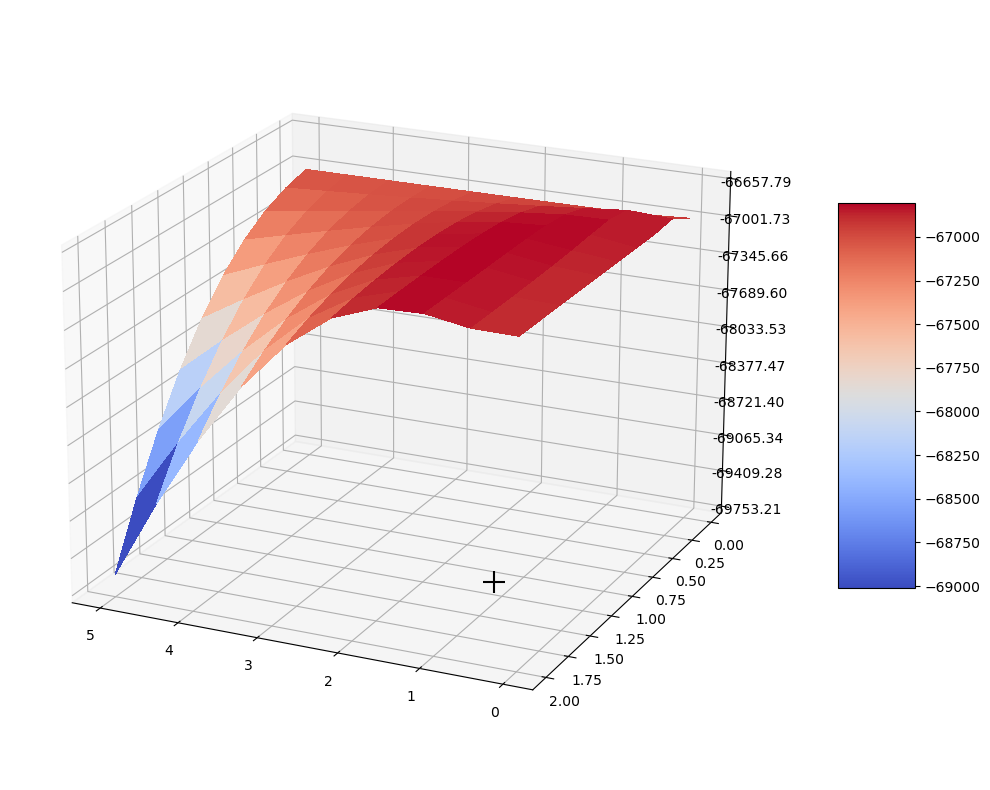

In [48]:
from matplotlib import cm
from matplotlib.ticker import LinearLocator

fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize = (15,10))
# Set up plot
surf = ax.plot_surface(r_plot, s_plot, z2, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
#ax.set_zlim(-1.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.02f}')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.scatter(param_sample[0], param_sample[1], z2.min(), color = "black", marker = "+", s = 250)


ax.view_init(20, 115)
plt.show()

In [49]:
param_sample

array([0.99513994, 1.3447954 ])